In [ ]:


import os, gc, json, math, time, random
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models

# ================== GPU & Seed ==================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
        except Exception:
            pass

# ================== CONFIG ==================
# Thay đổi cho phù hợp dataset của bạn
TRAIN_DIR = "D:\Diux\hoctap\DoAn\ddr\\train_preprocess"
VAL_DIR   = "D:\Diux\hoctap\DoAn\ddr\\val_preprocess"

IMAGE_SIZE = 300 #448
BATCH_SIZE = 8

HEAD_EPOCHS = 10          # epochs cho stage 1 (train head)
FT_EPOCHS   = 10          # epochs cho mỗi state fine-tuning

LR_HEAD = 3e-4            # LR stage 1
LR_FT   = [1e-4, 5e-5, 3e-5]   # LR cho 3 state fine-tune
WEIGHT_DECAY = 1e-4

DROP_RATE   = 0.4
DENSE_UNITS = 1024

MODELS_DIR = "output_three_models_ddr"
os.makedirs(MODELS_DIR, exist_ok=True)

AUTOTUNE = tf.data.AUTOTUNE

# ================== EfficientNetB3 & Preprocess ==================
from tensorflow.keras.applications.efficientnet import EfficientNetB3, preprocess_input

# ================== Attention block (nhẹ) ==================
def sca_block(x, ratio=8, name="sca"):
    """Simple Channel Attention: GAP -> reduce(1x1) -> gate(1x1 sigmoid) -> multiply."""
    ch = int(x.shape[-1])
    mid = max(ch // ratio, 1)
    gap = layers.GlobalAveragePooling2D(keepdims=True, name=f"{name}_gap")(x)
    red = layers.Conv2D(mid, 1, padding="same", activation="relu", use_bias=True, name=f"{name}_reduce")(gap)
    gate= layers.Conv2D(ch,  1, padding="same", activation="sigmoid", use_bias=True, name=f"{name}_gate")(red)
    return layers.Multiply(name=f"{name}_mul")([x, gate])

# ================== Dataset helpers ==================
def _map_img(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img, lbl

def _ds_from_dir(data_dir, class_names, shuffle, seed=SEED):
    # Chỉ lấy các class cần 
    ds = tf.keras.utils.image_dataset_from_directory(
        data_dir,
        labels="inferred",
        label_mode="int",
        class_names=class_names,            
        color_mode="rgb",
        batch_size=BATCH_SIZE,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        shuffle=shuffle,
        seed=seed
    )
    return ds

# -------- Model 1: Low(0,1) vs High(2,3,4) --------
def map_label_low_high(label_int):
    # label_int in {0,1,2,3,4} -> 0 if in {0,1}, else 1
    y = tf.where(label_int <= 1, 0, 1)
    y = tf.cast(y, tf.float32)
    return y

def map_preprocess_m1(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = map_label_low_high(lbl)
    y = tf.expand_dims(y, axis=-1)  # (B,1) sigmoid
    return img, y

def make_ds_m1(train_dir, val_dir):
    class_names = ["0","1","2","3","4"]
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m1, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m1, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# -------- Model 2: Binary 0 vs 1 --------
def map_preprocess_m2(img, lbl):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = tf.cast(lbl, tf.float32)      
    y = tf.expand_dims(y, axis=-1)    # (B,1) sigmoid
    return img, y

def make_ds_m2(train_dir, val_dir):
    class_names = ["0","1"]  # chỉ lấy hai lớp này, tự động bỏ qua 2,3,4 
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m2, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m2, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# -------- Model 3: Ordinal for {2,3,4} with 2-bit [y>=3, y>=4] --------
def ordinal_encode_234(label_idx):

    t1 = tf.cast(label_idx >= 1, tf.float32)
    t2 = tf.cast(label_idx >= 2, tf.float32)
    y = tf.stack([t1, t2], axis=-1)  # (B,2)
    return y

def map_preprocess_m3(img, lbl_idx):
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    y = ordinal_encode_234(lbl_idx)
    return img, y

def make_ds_m3(train_dir, val_dir):
    class_names = ["2","3","4"]
    ds_tr = _ds_from_dir(train_dir, class_names, shuffle=True).map(map_preprocess_m3, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    ds_va = _ds_from_dir(val_dir,   class_names, shuffle=False).map(map_preprocess_m3, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
    return ds_tr, ds_va

# ================== Model builders ==================
def build_backbone_b3(inputs, freeze=True):
    base = EfficientNetB3(include_top=False, weights="imagenet", input_tensor=inputs)
    base.trainable = not freeze
    return base

def build_head(x, drop=DROP_RATE, units=DENSE_UNITS, name_prefix="head"):
    x = sca_block(x, ratio=8, name=f"{name_prefix}_sca")
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(drop)(x)
    x = layers.Dense(units, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(drop * 0.75)(x)
    return x

# ---- Model 1: binary Low vs High (sigmoid 1 unit) ----
def build_model_1(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m1")
    out = layers.Dense(1, activation="sigmoid", name="bin")(x)
    return models.Model(inputs, out, name="EffB3_M1_LowHigh")

# ---- Model 2: binary 0 vs 1 (sigmoid 1 unit) ----
def build_model_2(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m2")
    out = layers.Dense(1, activation="sigmoid", name="bin")(x)
    return models.Model(inputs, out, name="EffB3_M2_0vs1")

# ---- Model 3: ordinal for 2,3,4 → 2-bit sigmoid [y>=3, y>=4] ----
def build_model_3(img_size=IMAGE_SIZE, freeze_backbone=True):
    inputs = layers.Input(shape=(img_size, img_size, 3))
    base = build_backbone_b3(inputs, freeze=freeze_backbone)
    x = build_head(base.output, name_prefix="m3")
    out = layers.Dense(2, activation="sigmoid", name="ord2")(x)
    return models.Model(inputs, out, name="EffB3_M3_234Ordinal")

# ================== Compile helpers ==================
def compile_binary(model, lr, wd=WEIGHT_DECAY):
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.BinaryAccuracy(name="acc"), tf.keras.metrics.AUC(name="auc")]
    )
    return model

def compile_multi_sigmoid(model, lr, wd=WEIGHT_DECAY):
    # For model 3: 2 independent sigmoids (multi-label BCE)
    try:
        opt = tf.keras.optimizers.AdamW(learning_rate=lr, weight_decay=wd)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
        metrics=[tf.keras.metrics.AUC(name="auc", multi_label=True)]
    )
    return model

# ================== Fine-tune utilities ==================
def set_trainable_blocks(model, prefixes_to_unfreeze):

    for layer in model.layers:
        name = getattr(layer, "name", "")
        if any(name.startswith(pfx) for pfx in prefixes_to_unfreeze):
            layer.trainable = True
        # Freeze all BN layers
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

def run_stage_training(model, ds_train, ds_val, epochs, lr, ckpt_path, is_binary=True):
    
    if is_binary:
        compile_binary(model, lr)
    else:
        compile_multi_sigmoid(model, lr)

    cbs = [
        tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
        tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True)
    ]
    history = model.fit(ds_train, validation_data=ds_val, epochs=epochs, callbacks=cbs, verbose=1)
    # Save snapshot 
    model.save(ckpt_path)
    return history

def staged_finetune_pipeline(model_name_prefix,
                             build_fn,
                             ds_train,
                             ds_val,
                             is_binary,
                             head_epochs=HEAD_EPOCHS,
                             ft_epochs=FT_EPOCHS,
                             lr_head=LR_HEAD,
                             lr_stages=LR_FT):
    """
    Generic 4-stage pipeline:
      Stage 1: Train head (frozen backbone)
      Stage 2: unfreeze block6..7
      Stage 3: unfreeze block4..7
      Stage 4: unfreeze block1..7
    """
    # -------- Stage 1 --------
    s1_path = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage1.keras")
    if os.path.exists(s1_path):
        print(f"[{model_name_prefix}] Found Stage1 checkpoint, loading:", s1_path)
        model = tf.keras.models.load_model(s1_path, compile=False)
    else:
        print(f"\n[{model_name_prefix}] === Stage 1: Train head (backbone frozen) ===")
        model = build_fn(freeze_backbone=True)
        if is_binary:
            compile_binary(model, lr_head)
        else:
            compile_multi_sigmoid(model, lr_head)
        run_stage_training(model, ds_train, ds_val, head_epochs, lr_head, s1_path, is_binary=is_binary)

    # -------- Stage 2~4 (fine-tuning) --------
    stage_blocks = [
        ["block6", "block7"],
        ["block4", "block5", "block6", "block7"],
        ["block1", "block2", "block3", "block4", "block5", "block6", "block7"],
    ]
    for idx, (prefixes, lr) in enumerate(zip(stage_blocks, lr_stages), start=2):
        ck = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage{idx}.keras")
        if os.path.exists(ck):
            print(f"[{model_name_prefix}] Found Stage{idx} checkpoint, loading:", ck)
            continue
        # Always reload previous best to reduce memory usage and ensure good init
        prev = os.path.join(MODELS_DIR, f"{model_name_prefix}_stage{idx-1}.keras")
        print(f"\n[{model_name_prefix}] === Stage {idx}: Unfreeze {prefixes} ===")
        model = tf.keras.models.load_model(prev, compile=False)
        set_trainable_blocks(model, prefixes)
        # Keep head layers trainable by default (already True)
        run_stage_training(model, ds_train, ds_val, ft_epochs, lr, ck, is_binary=is_binary)

    print(f"\n[{model_name_prefix}] === Completed all stages ===")



<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
<>:38: SyntaxWarning: invalid escape sequence '\D'
<>:39: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_8824\1234502136.py:38: SyntaxWarning: invalid escape sequence '\D'
  TRAIN_DIR = "D:\Diux\hoctap\DoAn\ddr\\train_preprocess"
C:\Users\tran1\AppData\Local\Temp\ipykernel_8824\1234502136.py:39: SyntaxWarning: invalid escape sequence '\D'
  VAL_DIR   = "D:\Diux\hoctap\DoAn\ddr\\val_preprocess"


In [2]:
# ================== MAIN ==================

    # -------- Datasets for each model --------
tf.keras.backend.clear_session(); gc.collect()
print("Preparing datasets...")
ds1_train, ds1_val = make_ds_m1(TRAIN_DIR, VAL_DIR)   # Low vs High
ds2_train, ds2_val = make_ds_m2(TRAIN_DIR, VAL_DIR)   # 0 vs 1
ds3_train, ds3_val = make_ds_m3(TRAIN_DIR, VAL_DIR)   # 2/3/4 ordinal 2-bit






Preparing datasets...
Found 20693 files belonging to 5 classes.
Found 2504 files belonging to 5 classes.
Found 8796 files belonging to 2 classes.
Found 1379 files belonging to 2 classes.
Found 11897 files belonging to 3 classes.
Found 1125 files belonging to 3 classes.


In [3]:
    # -------- Model 1 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_low_high",
        build_fn=lambda freeze_backbone=True: build_model_1(IMAGE_SIZE, freeze_backbone),
        ds_train=ds1_train,
        ds_val=ds1_val,
        is_binary=True,
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )



[effb3_low_high] === Stage 1: Train head (backbone frozen) ===
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 1649s 633ms/step - acc: 0.7760 - auc: 0.8506 - loss: 0.5562 - val_acc: 0.8063 - val_auc: 0.8762 - val_loss: 0.4353 - learning_rate: 3.0000e-04
Epoch 2/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 1522s 588ms/step - acc: 0.8262 - auc: 0.9030 - loss: 0.3944 - val_acc: 0.8171 - val_auc: 0.8932 - val_loss: 0.4113 - learning_rate: 3.0000e-04
Epoch 3/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 1564s 605ms/step - acc: 0.8369 - auc: 0.9162 - loss: 0.3633 - val_acc: 0.8171 - val_auc: 0.8909 - val_loss: 0.4112 - learning_rate: 3.0000e-04
Epoch 4/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 1634s 632ms/step - acc: 0.8471 - auc: 0.9193 - loss: 0.3574 - val_acc: 0.8155 - val_auc: 0.9041 - val_loss: 0.3995 - learning_rate: 3.0000e-04
Epoch 5/10
2587/2587 ━━━━━━━━━━━━━━━━━━━━ 1604s 620ms/step - acc: 0.8553 - auc: 0.9268 - loss: 0.3397 - val_acc: 0.8279 - val_auc: 0.8987 - val_l

C:\Users\tran1\AppData\Local\Temp\ipykernel_8824\1234502136.py:38: SyntaxWarning: invalid escape sequence '\D'
  TRAIN_DIR = "D:\Diux\hoctap\DoAn\ddr\\train_preprocess"
C:\Users\tran1\AppData\Local\Temp\ipykernel_8824\1234502136.py:39: SyntaxWarning: invalid escape sequence '\D'
  VAL_DIR   = "D:\Diux\hoctap\DoAn\ddr\\val_preprocess"


KeyboardInterrupt: 

In [ ]:
    # -------- Model 2 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_0_vs_1",
        build_fn=lambda freeze_backbone=True: build_model_2(IMAGE_SIZE, freeze_backbone),
        ds_train=ds2_train,
        ds_val=ds2_val,
        is_binary=True,
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )



In [3]:
    # -------- Model 3 pipeline --------
tf.keras.backend.clear_session(); gc.collect()
staged_finetune_pipeline(
        model_name_prefix="effb3_234_ordinal2bit",
        build_fn=lambda freeze_backbone=True: build_model_3(IMAGE_SIZE, freeze_backbone),
        ds_train=ds3_train,
        ds_val=ds3_val,
        is_binary=False,   # multi-label BCE for 2-bit ordinal
        head_epochs=HEAD_EPOCHS,
        ft_epochs=FT_EPOCHS,
        lr_head=LR_HEAD,
        lr_stages=LR_FT
    )

print("\nAll three pipelines finished.")


[effb3_234_ordinal2bit] === Stage 1: Train head (backbone frozen) ===
Epoch 1/10


I0000 00:00:1755492112.708608    3427 service.cc:152] XLA service 0x70ad14015970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755492112.708631    3427 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-08-18 00:41:53.250935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1755492115.485598    3427 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/550 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - auc: 0.6200 - loss: 0.8170   

I0000 00:00:1755492132.356057    3427 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


550/550 ━━━━━━━━━━━━━━━━━━━━ 67s 70ms/step - auc: 0.6485 - loss: 0.8265 - val_auc: 0.7194 - val_loss: 0.7643 - learning_rate: 3.0000e-04
Epoch 2/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - auc: 0.7370 - loss: 0.6333 - val_auc: 0.7614 - val_loss: 0.7002 - learning_rate: 3.0000e-04
Epoch 3/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - auc: 0.7720 - loss: 0.5693 - val_auc: 0.7373 - val_loss: 0.7516 - learning_rate: 3.0000e-04
Epoch 4/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 23s 43ms/step - auc: 0.7651 - loss: 0.5602 - val_auc: 0.7564 - val_loss: 0.8194 - learning_rate: 3.0000e-04
Epoch 5/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - auc: 0.7870 - loss: 0.5322 - val_auc: 0.7533 - val_loss: 0.7400 - learning_rate: 3.0000e-04
Epoch 6/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - auc: 0.8124 - loss: 0.4972 - val_auc: 0.7642 - val_loss: 0.6344 - learning_rate: 1.5000e-04
Epoch 7/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - auc: 0.8281 - loss: 0.4767 - val_auc: 0.7600 - val_loss: 0.6247 - l

2025-08-18 00:58:35.659868: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:382] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


550/550 ━━━━━━━━━━━━━━━━━━━━ 127s 136ms/step - auc: 0.9942 - loss: 0.0896 - val_auc: 0.7957 - val_loss: 0.8323 - learning_rate: 3.0000e-05
Epoch 2/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 63s 114ms/step - auc: 0.9978 - loss: 0.0551 - val_auc: 0.7670 - val_loss: 0.9952 - learning_rate: 3.0000e-05
Epoch 3/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 63s 114ms/step - auc: 0.9980 - loss: 0.0498 - val_auc: 0.7853 - val_loss: 1.0133 - learning_rate: 3.0000e-05
Epoch 4/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 63s 115ms/step - auc: 0.9983 - loss: 0.0449 - val_auc: 0.7702 - val_loss: 1.1866 - learning_rate: 3.0000e-05
Epoch 5/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 63s 115ms/step - auc: 0.9993 - loss: 0.0291 - val_auc: 0.7601 - val_loss: 1.0855 - learning_rate: 1.5000e-05
Epoch 6/10
550/550 ━━━━━━━━━━━━━━━━━━━━ 64s 117ms/step - auc: 0.9996 - loss: 0.0195 - val_auc: 0.7627 - val_loss: 1.2478 - learning_rate: 1.5000e-05

[effb3_234_ordinal2bit] === Completed all stages ===

All three pipelines finished.


<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\e'
<>:38: SyntaxWarning: invalid escape sequence '\e'
<>:39: SyntaxWarning: invalid escape sequence '\e'
C:\Users\tran1\AppData\Local\Temp\ipykernel_15476\3040932510.py:30: SyntaxWarning: invalid escape sequence '\D'
  ROOT_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"
C:\Users\tran1\AppData\Local\Temp\ipykernel_15476\3040932510.py:37: SyntaxWarning: invalid escape sequence '\e'
  M1_PATH = "output_three_models_ddr\effb3_low_high_stage4.keras"
C:\Users\tran1\AppData\Local\Temp\ipykernel_15476\3040932510.py:38: SyntaxWarning: invalid escape sequence '\e'
  M2_PATH = "output_three_models_ddr\effb3_0_vs_1_stage4.keras"
C:\Users\tran1\AppData\Local\Temp\ipykernel_15476\3040932510.py:39: Sy

Loading models...

=== Model 1: Low(0,1) vs High(2,3,4) ===
              precision    recall  f1-score   support

    Low(0,1)     0.8620    0.9594    0.9081       690
 High(2,3,4)     0.9423    0.8117    0.8721       563

    accuracy                         0.8931      1253
   macro avg     0.9021    0.8856    0.8901      1253
weighted avg     0.8981    0.8931    0.8919      1253



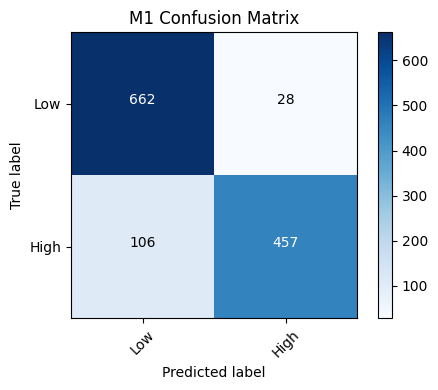


=== Model 2: 0 vs 1 ===
              precision    recall  f1-score   support

           0     0.9326    0.9713    0.9516       627
           1     0.5135    0.3016    0.3800        63

    accuracy                         0.9101       690
   macro avg     0.7231    0.6364    0.6658       690
weighted avg     0.8944    0.9101    0.8994       690



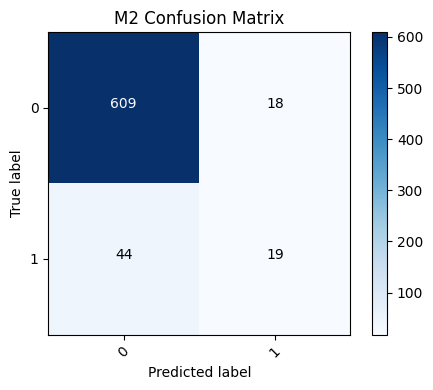


=== Model 3: 2/3/4 (ordinal 2-bit) ===
              precision    recall  f1-score   support

           2     0.9262    0.9799    0.9523       448
           3     0.5000    0.2083    0.2941        24
           4     0.8861    0.7692    0.8235        91

    accuracy                         0.9130       563
   macro avg     0.7707    0.6525    0.6900       563
weighted avg     0.9015    0.9130    0.9034       563



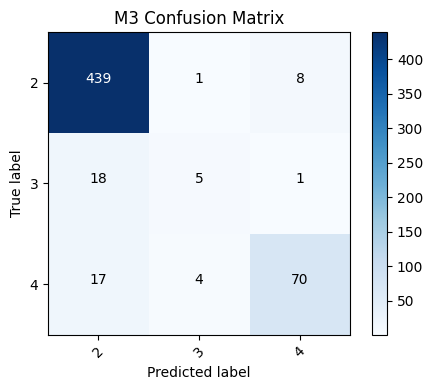


=== Unified system: 0..4 ===
              precision    recall  f1-score   support

           0     0.8464    0.9490    0.8947       627
           1     0.2000    0.2063    0.2031        63
           2     0.8463    0.7500    0.7953       448
           3     0.5000    0.2083    0.2941        24
           4     0.8846    0.7582    0.8166        91

    accuracy                         0.8125      1253
   macro avg     0.6555    0.5744    0.6008      1253
weighted avg     0.8100    0.8125    0.8072      1253



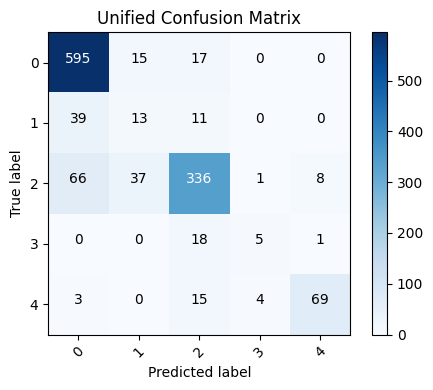


Done.


In [ ]:

import os, gc, random, numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# ============== CONFIG ==============
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)


ROOT_DIR = "D:\Diux\hoctap\DoAn\ddr\\test_preprocess"

IMAGE_SIZE = 300
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE


M1_PATH = "output_three_models_ddr\effb3_low_high_stage4.keras"
M2_PATH = "output_three_models_ddr\effb3_0_vs_1_stage4.keras"
M3_PATH = "output_three_models_ddr\effb3_234_ordinal2bit_stage4.keras"

# Ngưỡng
TH_BIN = 0.5   # cho sigmoid nhị phân (M1/M2)
TH_ORD = 0.5   # cho 2-bit ordinal (M3)

# ============== GPU ==============
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass

# ============== Data helpers ==============
CLASS_NAMES = ["0","1","2","3","4"]
CLASS_TO_INT = {c:i for i,c in enumerate(CLASS_NAMES)}  # "0"->0, ..., "4"->4

def list_images_with_labels(root, class_names=CLASS_NAMES):
    paths, labels = [], []
    for c in class_names:
        cdir = os.path.join(root, c)
        if not os.path.isdir(cdir):
            continue
        for fname in os.listdir(cdir):
            if fname.lower().endswith((".jpg",".jpeg",".png",".bmp",".tiff",".webp")):
                paths.append(os.path.join(cdir, fname))
                labels.append(int(c))
    return paths, np.array(labels, dtype=np.int32)

def _read_resize_preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE), method="bicubic")
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    return img

def make_dataset(root, batch_size=BATCH_SIZE, shuffle=False):
    paths, labels = list_images_with_labels(root, CLASS_NAMES)
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=False)
    def _map(path, y):
        img = _read_resize_preprocess(path)
        return img, y
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    return ds, paths, labels

# ============== Utility: plots & printing ==============
def plot_confusion_matrix(cm, labels, title="Confusion Matrix"):
    fig = plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.0 if cm.size else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def enforce_monotonic_ord(p_ord):
    """
    Ensure p(y>=4) <= p(y>=3) for ordinal outputs.
    p_ord: (N,2) -> [:,0]=p_ge3, [:,1]=p_ge4
    """
    p = p_ord.copy()
    p[:,1] = np.minimum(p[:,1], p[:,0])
    return p

def bits_to_234(bits):
    """
    bits: (N,2), each in {0,1}, [b_ge3, b_ge4]
    Decode to {2,3,4}:
      [0,0] -> 2
      [1,0] -> 3
      [1,1] -> 4
      [0,1] (invalid) -> fix to 3
    """
    out = np.full((bits.shape[0],), 3, dtype=np.int32)
    cond00 = (bits[:,0]==0) & (bits[:,1]==0)
    cond10 = (bits[:,0]==1) & (bits[:,1]==0)
    cond11 = (bits[:,0]==1) & (bits[:,1]==1)
    out[cond00] = 2
    out[cond10] = 3
    out[cond11] = 4
    return out

# ============== Load models ==============
def load_model_safely(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Model not found: {path}")
    return tf.keras.models.load_model(path, compile=False)

# ============== Evaluate Model 1: Low vs High ==============
def evaluate_model1(ds, y_true_0to4, m1, th=TH_BIN):
    # y_true_bin: 0 (low {0,1}), 1 (high {2,3,4})
    y_true_bin = (y_true_0to4 >= 2).astype(np.int32)
    y_pred_prob = []
    for xb, _ in ds:
        p = m1.predict(xb, verbose=0)
        y_pred_prob.append(p.ravel())
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)
    y_pred = (y_pred_prob >= th).astype(np.int32)

    print("\n=== Model 1: Low(0,1) vs High(2,3,4) ===")
    print(classification_report(y_true_bin, y_pred, target_names=["Low(0,1)","High(2,3,4)"], digits=4))
    cm = confusion_matrix(y_true_bin, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, labels=["Low","High"], title="M1 Confusion Matrix")
    return y_pred, y_pred_prob

# ============== Evaluate Model 2: 0 vs 1 ==============
def evaluate_model2(root_dir, m2, th=TH_BIN):
    # chỉ dùng lớp 0 và 1
    ds01, _, y_true01 = make_dataset(root_dir, shuffle=False)
    # lọc chỉ 0,1 ở y_true
    # (make_dataset đã lấy đủ 0..4; ta chỉ dựa vào root_dir có đủ 0,1)
    mask = (y_true01 <= 1)
    if not np.any(mask):
        print("\n[WARNING] Không tìm thấy lớp 0/1 trong thư mục để đánh giá M2.")
        return None, None, None
    # để đơn giản, tạo lại ds chỉ chứa 0/1
    paths_all, labels_all = list_images_with_labels(root_dir, CLASS_NAMES)
    paths01 = [p for p,l in zip(paths_all, labels_all) if l in (0,1)]
    y_true01 = np.array([l for l in labels_all if l in (0,1)], dtype=np.int32)

    # build ds 0/1 riêng
    def gen01():
        for p in paths01:
            yield p
    ds_paths = tf.data.Dataset.from_generator(gen01, output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    ds_img = ds_paths.map(lambda p: (_read_resize_preprocess(p)), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    y_pred_prob = []
    for xb in ds_img:
        p = m2.predict(xb, verbose=0)
        y_pred_prob.append(p.ravel())
    y_pred_prob = np.concatenate(y_pred_prob, axis=0)
    y_pred = (y_pred_prob >= th).astype(np.int32)

    print("\n=== Model 2: 0 vs 1 ===")
    print(classification_report(y_true01, y_pred, target_names=["0","1"], digits=4))
    cm = confusion_matrix(y_true01, y_pred, labels=[0,1])
    plot_confusion_matrix(cm, labels=["0","1"], title="M2 Confusion Matrix")
    return y_true01, y_pred, y_pred_prob

# ============== Evaluate Model 3: 2/3/4 ordinal ==============
def evaluate_model3(root_dir, m3, th=TH_ORD):
    # chỉ dùng lớp 2,3,4
    paths_all, labels_all = list_images_with_labels(root_dir, CLASS_NAMES)
    mask = np.isin(labels_all, [2,3,4])
    if not np.any(mask):
        print("\n[WARNING] Không tìm thấy lớp 2/3/4 trong thư mục để đánh giá M3.")
        return None, None, None
    paths234 = [p for p,l in zip(paths_all, labels_all) if l in (2,3,4)]
    y_true234 = np.array([l for l in labels_all if l in (2,3,4)], dtype=np.int32)

    def gen234():
        for p in paths234:
            yield p
    ds_paths = tf.data.Dataset.from_generator(gen234, output_signature=tf.TensorSpec(shape=(), dtype=tf.string))
    ds_img = ds_paths.map(lambda p: (_read_resize_preprocess(p)), num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

    proba = []
    for xb in ds_img:
        p = m3.predict(xb, verbose=0)  # (B,2) [p_ge3, p_ge4]
        proba.append(p)
    proba = np.concatenate(proba, axis=0)
    proba = enforce_monotonic_ord(proba)
    bits = (proba >= th).astype(np.int32)
    y_pred234 = bits_to_234(bits)

    print("\n=== Model 3: 2/3/4 (ordinal 2-bit) ===")
    # classification_report với labels [2,3,4]
    print(classification_report(y_true234, y_pred234, labels=[2,3,4], target_names=["2","3","4"], digits=4))
    cm = confusion_matrix(y_true234, y_pred234, labels=[2,3,4])
    plot_confusion_matrix(cm, labels=["2","3","4"], title="M3 Confusion Matrix")
    return y_true234, y_pred234, proba

# ============== Unified prediction (0..4) ==============
def unified_predict_and_eval(root_dir, m1, m2, m3, th_bin=TH_BIN, th_ord=TH_ORD):
    ds, paths, y_true = make_dataset(root_dir, shuffle=False)
    y_pred_all = []

    for xb, yb in ds:
        # 1) Low/High by M1: p_high
        p_high = m1.predict(xb, verbose=0).ravel()
        is_high = (p_high >= th_bin)

        # 2) Route low -> M2 ; high -> M3
        # Low subset
        x_low = xb[~is_high]
        # High subset
        x_high = xb[is_high]

        # Prepare container for this batch
        y_pred_batch = np.empty((xb.shape[0],), dtype=np.int32)

        # Low -> 0/1
        if x_low.shape[0] > 0:
            p01 = m2.predict(x_low, verbose=0).ravel()
            y01 = (p01 >= th_bin).astype(np.int32)  # 0 or 1
            y_pred_batch[~is_high] = y01

        # High -> 2/3/4 via ordinal
        if x_high.shape[0] > 0:
            p_ord = m3.predict(x_high, verbose=0)  # (n_high,2)
            p_ord = enforce_monotonic_ord(p_ord)
            bits = (p_ord >= th_ord).astype(np.int32)
            y234 = bits_to_234(bits)
            y_pred_batch[is_high] = y234

        y_pred_all.append(y_pred_batch)

    y_pred_all = np.concatenate(y_pred_all, axis=0)

    print("\n=== Unified system: 0..4 ===")
    print(classification_report(y_true, y_pred_all, labels=[0,1,2,3,4], target_names=["0","1","2","3","4"], digits=4))
    cm = confusion_matrix(y_true, y_pred_all, labels=[0,1,2,3,4])
    plot_confusion_matrix(cm, labels=["0","1","2","3","4"], title="Unified Confusion Matrix")

    return paths, y_true, y_pred_all

# ============== MAIN ==============

tf.keras.backend.clear_session(); gc.collect()

    # Load models
print("Loading models...")
m1 = load_model_safely(M1_PATH)  # Low/High
m2 = load_model_safely(M2_PATH)  # 0 vs 1
m3 = load_model_safely(M3_PATH)  # 2/3/4 ordinal

    # Evaluate M1 on full folder (0..4)
ds_full, paths_full, y_full = make_dataset(ROOT_DIR, shuffle=False)
_m1_pred, _m1_prob = evaluate_model1(ds_full, y_full, m1, th=TH_BIN)

    # Evaluate M2 on 0/1 subset
evaluate_model2(ROOT_DIR, m2, th=TH_BIN)

    # Evaluate M3 on 2/3/4 subset 
evaluate_model3(ROOT_DIR, m3, th=TH_ORD)

    # Unified evaluation on full folder (0..4)
unified_predict_and_eval(ROOT_DIR, m1, m2, m3, th_bin=TH_BIN, th_ord=TH_ORD)

print("\nDone.")


In [2]:
!ipynb-py-convert structure_model_v5_for_aptos2019.ipynb structure_model_v5_for_aptos2019.py

In [6]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
import numpy as np
IMAGE_SIZE = 300          # dùng đúng kích thước lúc train (300 hoặc 448 tuỳ bạn)
TH_BIN = 0.5
M1_PATH = "output_three_models_ddr\effb3_low_high_stage4.keras"
M2_PATH = "output_three_models_ddr\effb3_0_vs_1_stage4.keras"
M3_PATH = "output_three_models_ddr\effb3_234_ordinal2bit_stage4.keras"
m1 = tf.keras.models.load_model(M1_PATH, compile=False)
m2 = tf.keras.models.load_model(M2_PATH, compile=False)
m3 = tf.keras.models.load_model(M3_PATH, compile=False)


<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\e'
C:\Users\tran1\AppData\Local\Temp\ipykernel_17452\3444970214.py:6: SyntaxWarning: invalid escape sequence '\e'
  M1_PATH = "output_three_models_ddr\effb3_low_high_stage4.keras"
C:\Users\tran1\AppData\Local\Temp\ipykernel_17452\3444970214.py:7: SyntaxWarning: invalid escape sequence '\e'
  M2_PATH = "output_three_models_ddr\effb3_0_vs_1_stage4.keras"
C:\Users\tran1\AppData\Local\Temp\ipykernel_17452\3444970214.py:8: SyntaxWarning: invalid escape sequence '\e'
  M3_PATH = "output_three_models_ddr\effb3_234_ordinal2bit_stage4.keras"


In [10]:


def m1_prob_high(y):
    """m1 nhị phân low/high. Hỗ trợ (N,1) sigmoid hoặc (N,2) softmax."""
    y = np.asarray(y)
    p_high = y[:, 0]  # sigmoid
    
    return p_high
def m2_prob_class1(y):
    """m2 0/1. Trả về p(class 1)."""
    y = np.asarray(y)
    p1 = y[:, 0]  # sigmoid
    return p1
def m3_decode_234(y2bit):
    """
    m3 ordinal 2-bit (giả định [p>=3, p>=4] sau sigmoid).
    Suy ra phân phối trên {2,3,4}:
      p2 = 1 - p>=3
      p3 = p>=3 - p>=4
      p4 = p>=4
    Trả về: (labels_234, dist_234) với labels_234 ∈ {2,3,4}
    """
    y = np.asarray(y2bit, dtype=np.float32)
    if y.ndim != 2 or y.shape[1] != 2:
        raise ValueError("m3 (ordinal 2-bit) phải có shape (N,2) ~ [p>=3, p>=4].")
    p_ge3, p_ge4 = y[:, 0], y[:, 1]
    p2 = 1.0 - p_ge3
    p3 = p_ge3 - p_ge4
    p4 = p_ge4
    P = np.stack([p2, p3, p4], axis=1)
    P = np.clip(P, 1e-9, None)
    P = P / P.sum(axis=1, keepdims=True)
    labels_local = np.argmax(P, axis=1)  # 0->2, 1->3, 2->4
    labels_global = labels_local + 2
    return labels_global, P
def predict_model1(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMAGE_SIZE, IMAGE_SIZE), method="bicubic")
    img = tf.cast(img, tf.float32)
    img = preprocess_input(img)
    x = tf.expand_dims(img, 0)  # (1,H,W,3)
    pre1=m1.predict(x, verbose=0)
    pre2=m2.predict(x, verbose=0)
    pre3=m3.predict(x, verbose=0)
    # p_high = float(preC[0, 0])   # xác suất thuộc High
    # pred = "High (2,3,4)" if p_high >= TH_BIN else "Low (0,1)"
    print("1=>",pre1)
    print(m1_prob_high(pre1))
    print("2=>",pre2)
    lab2    = (pre2 >= TH_BIN).astype(np.int32)
    print(m2_prob_class1(pre2),"  ",lab2)
    
    print("3=>",pre3)
    print(m3_decode_234(pre3))
   

# ---- Demo ví dụ ----
predict_model1("D:\Diux\hoctap\DoAn\ddr\\test_preprocess\\2\\20170629164127116.jpg")

# Ví dụ output:
# {'p_high': 0.8321, 'p_low': 0.1679, 'threshold': 0.5, 'prediction': 'High (2,3,4)'}


<>:57: SyntaxWarning: invalid escape sequence '\D'
<>:57: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_17452\1414960312.py:57: SyntaxWarning: invalid escape sequence '\D'
  predict_model1("D:\Diux\hoctap\DoAn\ddr\\test_preprocess\\2\\20170629164127116.jpg")


1=> [[0.51781505]]
[0.51781505]
2=> [[0.32492813]]
[0.32492813]    [[0]]
3=> [[1.1822569e-05 6.4571846e-06]]
(array([2]), array([[9.9998820e-01, 5.3653844e-06, 6.4571846e-06]], dtype=float32))


<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\D'
<>:16: SyntaxWarning: invalid escape sequence '\e'
<>:17: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:19: SyntaxWarning: invalid escape sequence '\e'
<>:21: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_15824\4188298842.py:16: SyntaxWarning: invalid escape sequence '\e'
  M1_PATH = "output_three_models_ddr\effb3_low_high_stage4.keras"       # Model A
C:\Users\tran1\AppData\Local\Temp\ipykernel_15824\4188298842.py:17: SyntaxWarning: invalid escape sequence '\e'
  M2_PATH = "output_three_models_ddr\effb3_0_vs_1_stage4.keras"         # Model B
C:\Users\tran1\AppData\Local\Temp\ipykernel_15824\4188298842.py:18: SyntaxWarning: invalid escape sequ

Classification Report:
              precision    recall  f1-score   support

           0     0.8470    0.9091    0.8769       627
           1     0.1485    0.2381    0.1829        63
           2     0.8170    0.7076    0.7584       448
           3     0.3571    0.2083    0.2632        24
           4     0.9091    0.7692    0.8333        91

    accuracy                         0.7797      1253
   macro avg     0.6157    0.5665    0.5829      1253
weighted avg     0.7963    0.7797    0.7847      1253



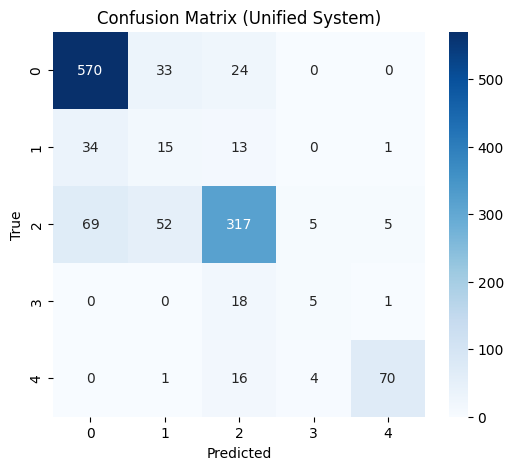

In [3]:
import os, gc, random
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ================= CONFIG =================
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

IMG_SIZE = 300   # ảnh gốc 600x600
BATCH_SIZE = 8

# Đường dẫn model (đã fine-tune xong)
M1_PATH = "output_three_models_ddr\effb3_low_high_stage4.keras"       # Model A
M2_PATH = "output_three_models_ddr\effb3_0_vs_1_stage4.keras"         # Model B
M3_PATH = "output_three_models_ddr\effb3_234_ordinal2bit_stage4.keras" # Model C
M4_PATH = "output_three_models_ddr\effb3_ddr_ordinal_v4_stage2.keras"        # Model D

TEST_DIR = "\Diux\hoctap\DoAn\ddr\\test_preprocess"

TH_BIN = 0.5
TH_ORD = 0.5

# ================= Load models =================
def load_model(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Not found: {path}")
    return tf.keras.models.load_model(path, compile=False)

mA = load_model(M1_PATH,)
mB = load_model(M2_PATH)
mC = load_model(M3_PATH)
mD = load_model(M4_PATH)

# ================= Dataset =================
def list_images(root):
    paths, labels = [], []
    for c in ["0","1","2","3","4"]:
        cdir = os.path.join(root, c)
        if not os.path.isdir(cdir): continue
        for fname in os.listdir(cdir):
            if fname.lower().endswith((".jpg",".jpeg",".png")):
                paths.append(os.path.join(cdir, fname))
                labels.append(int(c))
    return paths, np.array(labels)

def preprocess(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_image(img, channels=3, expand_animations=False)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32)
    img = tf.keras.applications.efficientnet.preprocess_input(img)
    return img

paths, y_true = list_images(TEST_DIR)
ds = tf.data.Dataset.from_tensor_slices(paths).map(lambda p: preprocess(p)).batch(BATCH_SIZE)

# ================= Helper decode =================
def decode_ord_D(pred4):
    # Model D output (N,4): [p>=1,p>=2,p>=3,p>=4]
    return np.sum(pred4 >= 0.5, axis=1)

def decode_ord_C(pred2):
    # Model C output (N,2): [p>=3, p>=4]
    bits = (pred2 >= TH_ORD).astype(int)
    out = np.full((pred2.shape[0],), 3)
    out[(bits[:,0]==0)&(bits[:,1]==0)] = 2
    out[(bits[:,0]==1)&(bits[:,1]==0)] = 3
    out[(bits[:,0]==1)&(bits[:,1]==1)] = 4
    return out

# ================= Unified prediction =================
all_preds = []
idx = 0
for xb in ds:
    n = xb.shape[0]

    # Model outputs
    
    
    pA = mA.predict(xb, verbose=0).ravel()      # prob high
    pB = mB.predict(xb, verbose=0).ravel()      # prob class=1
    pC = mC.predict(xb, verbose=0)              # (n,2)
    pD = mD.predict(xb, verbose=0)              # (n,4)

    yA = (pA >= TH_BIN).astype(int)             # 0=low,1=high
    yD = decode_ord_D(pD)

    y_batch = np.zeros(n, dtype=int)

    for i in range(n):
        # ===== Step 2: Low branch =====
        if yD[i] in (0,1) and yA[i]==0:
            yB = int(pB[i]>=TH_BIN)
            if yB == yD[i]:
                y_batch[i] = yD[i]
            else:
                # chọn model tự tin hơn
                confB = abs(pB[i]-0.5)
                confD = np.max([pD[i,0]-0.5, pD[i,1]-0.5, pD[i,2]-0.5, pD[i,3]-0.5])
                y_batch[i] = yB if confB>confD else yD[i]

        # ===== Step 3: High branch =====
        elif yD[i] in (2,3,4) and yA[i]==1:
            yC = decode_ord_C(pC[i:i+1])[0]
            if yC == yD[i]:
                y_batch[i] = yD[i]
            else:
                confC = np.max(np.abs(pC[i]-0.5))
                confD = np.max(np.abs(pD[i]-0.5))
                y_batch[i] = yC if confC>confD else yD[i]

        # ===== Step 6: conflict ngay từ đầu =====
        else:
            confA = abs(pA[i]-0.5)
            confD = np.max(np.abs(pD[i]-0.5))
            if confA > confD:
                y_batch[i] = 0 if yA[i]==0 else 2  # ép theo low/high
            else:
                y_batch[i] = yD[i]

    all_preds.append(y_batch)
    idx += n

y_pred = np.concatenate(all_preds, axis=0)

# ================= Evaluate =================
print("Classification Report:")
print(classification_report(y_true, y_pred, labels=[0,1,2,3,4], digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Unified System)")
plt.show()


In [2]:
# predict_low_high_misclassified.py
# In các ảnh dự đoán sai cho bài toán Low(0,1) vs High(2,3,4)
import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input

# ================== CONFIG ==================
MODEL_PATH = "D:\Diux\hoctap\DoAn\output_three_models_ddr\effb3_low_high_stage4.keras"  # chỉnh lại nếu khác
DATA_DIR = "\Diux\hoctap\DoAn\ddr\\test_preprocess"
                       # root có 5 thư mục con 0..4
BATCH_SIZE = 16
THRESHOLD  = 0.5  # sigmoid threshold

# ================== GPU optional ==================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass

# ================== Helpers ==================
def list_images_with_labels(root):
    """Trả về list filepaths và y_true(0..4) từ cấu trúc thư mục root/0..4."""
    paths, labels = [], []
    for cls in ["0","1","2","3","4"]:
        cdir = Path(root) / cls
        if not cdir.is_dir():
            continue
        for p in sorted(cdir.glob("*")):
            if p.suffix.lower() in [".jpg",".jpeg",".png",".bmp",".webp",".tif",".tiff"]:
                paths.append(str(p))
                labels.append(int(cls))
    return np.array(paths), np.array(labels, dtype=np.int32)

def to_low_high(y_0to4):
    """0 nếu {0,1} ; 1 nếu {2,3,4}."""
    return (y_0to4 >= 2).astype(np.int32)

def infer_input_hw(model):
    """Lấy (H,W) từ input_shape model."""
    ishape = model.input_shape
    if isinstance(ishape, list):
        ishape = ishape[0]
    H, W = ishape[1], ishape[2]
    if H is None or W is None:
        H = W = 300  # fallback theo EffNetB3 mặc định file train
    return int(H), int(W)

def load_and_preprocess_batch(filepaths, target_size):
    """Đọc batch ảnh -> tensor (N,H,W,3) đã preprocess EfficientNet."""
    H, W = target_size
    imgs = []
    for fp in filepaths:
        img = tf.io.read_file(fp)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, (H, W), method="bilinear")
        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)
        imgs.append(img)
    return tf.stack(imgs, axis=0).numpy()

def binary_pred_from_model_outputs(y):
    """
    Hỗ trợ cả (N,1) sigmoid hoặc (N,2) softmax.
    Trả về: p_high (N,), y_pred (0/1)
    """
    y = np.asarray(y)
    if y.ndim == 2 and y.shape[1] == 1:
        p_high = y[:, 0]                       # sigmoid cho lớp "high"
    elif y.ndim == 2 and y.shape[1] == 2:
        p_high = y[:, 1] / np.clip(y.sum(axis=1), 1e-9, None)  # softmax
    else:
        raise ValueError("Đầu ra model phải là (N,1) hoặc (N,2).")
    y_pred = (p_high >= THRESHOLD).astype(np.int32)
    return p_high, y_pred

def batch_indices(n, bs):
    i = 0
    while i < n:
        j = min(i + bs, n)
        yield i, j
        i = j

# ================== MAIN ==================
if __name__ == "__main__":
    # 1) Load model
    if not os.path.exists(MODEL_PATH):
        raise FileNotFoundError(f"Không thấy model: {MODEL_PATH}")
    model = tf.keras.models.load_model(MODEL_PATH, compile=False)
    in_size = infer_input_hw(model)
    print(f"Loaded model: {MODEL_PATH} | input size = {in_size}")

    # 2) Load file list & labels
    files, y_true_0to4 = list_images_with_labels(DATA_DIR)
    if len(files) == 0:
        raise RuntimeError(f"Không tìm thấy ảnh trong: {DATA_DIR}")
    y_true_bin = to_low_high(y_true_0to4)  # 0=Low, 1=High
    N = len(files)
    print(f"Tìm thấy {N} ảnh trong {DATA_DIR}")

    # 3) Predict theo batch
    y_pred_all = np.zeros((N,), dtype=np.int32)
    for i, j in batch_indices(N, BATCH_SIZE):
        batch_paths = files[i:j]
        xb = load_and_preprocess_batch(batch_paths, in_size)
        y_raw = model.predict(xb, verbose=0)
        _, y_pred = binary_pred_from_model_outputs(y_raw)
        y_pred_all[i:j] = y_pred

    # 4) In các ảnh dự đoán sai
    wrong_idx = np.where(y_pred_all != y_true_bin)[0]
    n_wrong = wrong_idx.size
    print("\n===== MISCLASSIFIED (Low/High) =====")
    print(f"Tổng số sai: {n_wrong} / {N}\n")
    for k in wrong_idx:
        fname = os.path.basename(files[k])
        t = "low" if y_true_bin[k] == 0 else "high"
        p = "low" if y_pred_all[k] == 0 else "high"
        print(f"{fname}\ttrue={t}\tpred={p}")


<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
<>:10: SyntaxWarning: invalid escape sequence '\D'
<>:11: SyntaxWarning: invalid escape sequence '\D'
C:\Users\tran1\AppData\Local\Temp\ipykernel_17452\249846709.py:10: SyntaxWarning: invalid escape sequence '\D'
  MODEL_PATH = "D:\Diux\hoctap\DoAn\output_three_models_ddr\effb3_low_high_stage4.keras"  # chỉnh lại nếu khác
C:\Users\tran1\AppData\Local\Temp\ipykernel_17452\249846709.py:11: SyntaxWarning: invalid escape sequence '\D'
  DATA_DIR = "\Diux\hoctap\DoAn\ddr\\test_preprocess"


Loaded model: D:\Diux\hoctap\DoAn\output_three_models_ddr\effb3_low_high_stage4.keras | input size = (300, 300)
Tìm thấy 1253 ảnh trong \Diux\hoctap\DoAn\ddr\test_preprocess

===== MISCLASSIFIED (Low/High) =====
Tổng số sai: 135 / 1253

007-0548-000.jpg	true=low	pred=high
007-1056-000.jpg	true=low	pred=high
007-1131-000.jpg	true=low	pred=high
007-1289-000.jpg	true=low	pred=high
007-1658-000.jpg	true=low	pred=high
007-1891-100.jpg	true=low	pred=high
007-1982-100.jpg	true=low	pred=high
007-1993-100.jpg	true=low	pred=high
007-2130-100.jpg	true=low	pred=high
007-3131-100.jpg	true=low	pred=high
007-7610-601.jpg	true=low	pred=high
007-7866-601.jpg	true=low	pred=high
007-8237-602.jpg	true=low	pred=high
20161112011316860.jpg	true=low	pred=high
20170206143044048.jpg	true=low	pred=high
20170220100624432.jpg	true=low	pred=high
20170224144635533.jpg	true=low	pred=high
20170228164709059.jpg	true=low	pred=high
20170323130757983.jpg	true=low	pred=high
20170409202147097.jpg	true=low	pred=high
20170426

Loading models...
Loaded.
Found 366 images for evaluation.

==== Routing summary ====
Pick m2 directly: 189
Pick m3 directly: 168
Fallback via m1 -> low (use m2): 7
Fallback via m1 -> high (use m3): 2

Classification Report (0..4):
              precision    recall  f1-score   support

           0     0.9750    0.8667    0.9176       180
           1     0.2222    0.2162    0.2192        37
           2     0.6279    0.8100    0.7074       100
           3     0.2609    0.3000    0.2791        20
           4     0.6667    0.4138    0.5106        29

    accuracy                         0.7186       366
   macro avg     0.5505    0.5213    0.5268       366
weighted avg     0.7406    0.7186    0.7225       366



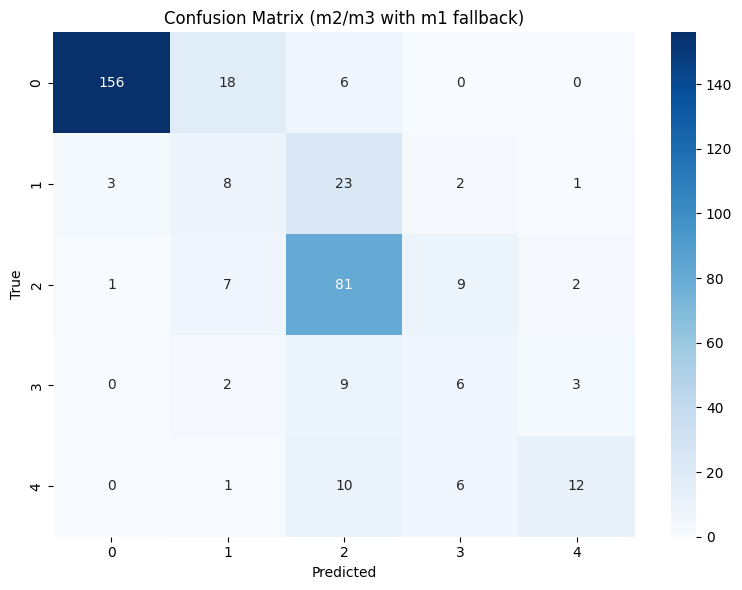

In [ ]:
# evaluate_three_models_rule_based.py
# -----------------------------------
# Luồng gán nhãn:
# 1) Đưa ảnh vào cả 3 model (m1: low/high, m2: 0/1, m3: 2/3/4 ordinal 2-bit).
# 2) Nếu p_m2 in [1e-5, 0.99999] -> gán nhãn theo m2 (0/1) rồi thoát.
# 3) Ngược lại (p_m2 ngoài khoảng), xét m3:
#    Nếu cả 2 giá trị đầu ra của m3 >= 1e-8 -> gán nhãn theo m3 (2/3/4) rồi thoát.
# 4) Nếu vẫn không thoả, dùng m1 quyết định route:
#    - m1=low -> lấy nhãn m2 (0/1, theo ngưỡng 0.5)
#    - m1=high -> lấy nhãn m3 (2/3/4, theo ordinal decode)
#
# Đánh giá: classification_report + confusion matrix heatmap.

import os
from pathlib import Path
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ================== CONFIG ==================
IMAGE_SIZE = 300  # dùng đúng kích thước lúc train các model EffNetB3
TH_BIN = 0.5

M1_PATH = "output_three_models/effb3_low_high_stage4.keras"           # low/high
M2_PATH = "output_three_models/effb3_0_vs_1_stage4.keras"             # 0 vs 1 (sigmoid/softmax)
M3_PATH = "output_three_models/effb3_234_ordinal2bit_stage4.keras"    # ordinal 2-bit cho {2,3,4}

# Thư mục test có cấu trúc: TEST_DIR/0..4/*.jpg
TEST_DIR = "aptos2019-blindness-detection/val_preprocess"

# Ngưỡng theo yêu cầu
M2_MIN, M2_MAX = 1e-8, 0.99999   # khoảng “chấp nhận ngay” cho m2
M3_MIN,M3_MAX = 1e-8,0.99999                    # cả 2 giá trị m3 phải >= M3_MIN để “chấp nhận ngay”
BATCH_SIZE = 16

# ================== GPU optional ==================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for g in gpus:
        try:
            tf.config.experimental.set_memory_growth(g, True)
        except Exception:
            pass

# ================== Helpers ==================
def list_images_with_labels(root):
    paths, labels = [], []
    for cls in ["0","1","2","3","4"]:
        cdir = Path(root) / cls
        if not cdir.is_dir():
            continue
        for p in sorted(cdir.glob("*")):
            if p.suffix.lower() in [".jpg", ".jpeg", ".png", ".bmp", ".webp", ".tif", ".tiff"]:
                paths.append(str(p))
                labels.append(int(cls))
    return np.array(paths), np.array(labels, dtype=np.int32)

def load_and_preprocess_batch(filepaths, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    H, W = target_size
    imgs = []
    for fp in filepaths:
        img = tf.io.read_file(fp)
        img = tf.image.decode_image(img, channels=3, expand_animations=False)
        img = tf.image.resize(img, (H, W), method="bicubic")
        img = tf.cast(img, tf.float32)
        img = preprocess_input(img)  # EfficientNet preprocess
        imgs.append(img)
    return tf.stack(imgs, axis=0).numpy()

def m1_prob_high(y):
    """m1 nhị phân low/high. Hỗ trợ (N,1) sigmoid hoặc (N,2) softmax."""
    y = np.asarray(y)
    p_high = y[:, 0]  # sigmoid
    
    return p_high
def m2_prob_class1(y):
    """m2 0/1. Trả về p(class 1)."""
    y = np.asarray(y)
    p1 = y[:, 0]  # sigmoid
    return p1

def m3_decode_234(y2bit):
    """
    m3 ordinal 2-bit (giả định [p>=3, p>=4] sau sigmoid).
    Suy ra phân phối trên {2,3,4}:
      p2 = 1 - p>=3
      p3 = p>=3 - p>=4
      p4 = p>=4
    Trả về: (labels_234, dist_234) với labels_234 ∈ {2,3,4}
    """
    y = np.asarray(y2bit, dtype=np.float32)
    if y.ndim != 2 or y.shape[1] != 2:
        raise ValueError("m3 (ordinal 2-bit) phải có shape (N,2) ~ [p>=3, p>=4].")
    p_ge3, p_ge4 = y[:, 0], y[:, 1]
    p2 = 1.0 - p_ge3
    p3 = p_ge3 - p_ge4
    p4 = p_ge4
    P = np.stack([p2, p3, p4], axis=1)
    P = np.clip(P, 1e-9, None)
    P = P / P.sum(axis=1, keepdims=True)
    labels_local = np.argmax(P, axis=1)  # 0->2, 1->3, 2->4
    labels_global = labels_local + 2
    return labels_global, P

def batch_indices(n, bs):
    i = 0
    while i < n:
        j = min(i + bs, n)
        yield i, j
        i = j

def to_rgb(x):
    return tf.image.grayscale_to_rgb(x)
# ================== Load models ==================
print("Loading models...")
m1 = tf.keras.models.load_model(M1_PATH, compile=False,safe_mode=False,  # cho phép revive Lambda/custom
            custom_objects={
                "to_rgb": to_rgb,
                "grayscale_to_rgb": tf.image.grayscale_to_rgb
            })
m2 = tf.keras.models.load_model(M2_PATH, compile=False,safe_mode=False,  # cho phép revive Lambda/custom
            custom_objects={
                "to_rgb": to_rgb,
                "grayscale_to_rgb": tf.image.grayscale_to_rgb
            })
m3 = tf.keras.models.load_model(M3_PATH, compile=False,safe_mode=False,  # cho phép revive Lambda/custom
            custom_objects={
                "to_rgb": to_rgb,
                "grayscale_to_rgb": tf.image.grayscale_to_rgb
            })
print("Loaded.")

# ================== Load test set ==================
files, y_true = list_images_with_labels(TEST_DIR)
if len(files) == 0:
    raise RuntimeError(f"Không tìm thấy ảnh trong: {TEST_DIR}")
N = len(files)
print(f"Found {N} images for evaluation.")

# ================== Predict (batched) ==================
y_pred = np.zeros((N,), dtype=np.int32)

# Đếm xem mỗi quyết định đi theo nhánh nào 
cnt_pick_m2 = 0
cnt_pick_m3 = 0
cnt_pick_m1_route_low = 0
cnt_pick_m1_route_high = 0

for a, b in batch_indices(N, BATCH_SIZE):
    fps = files[a:b]
    xb = load_and_preprocess_batch(fps, (IMAGE_SIZE, IMAGE_SIZE))

    y1_raw = m1.predict(xb, verbose=0)  # low/high
    y2_raw = m2.predict(xb, verbose=0)  # 0/1
    y3_raw = m3.predict(xb, verbose=0)  # 2-bit ordinal

    # Chuẩn bị các biến xác suất/nhãn
    p1_high = m1_prob_high(y1_raw)               # (B,)
    p2_one  = m2_prob_class1(y2_raw)             # (B,)
    lab2    = (p2_one >= TH_BIN).astype(np.int32)  # 0/1
    lab3, dist3 = m3_decode_234(y3_raw)          # ∈ {2,3,4}

    # Điều kiện m2 
    accept_m2 = (p2_one >= M2_MIN) & (p2_one <= M2_MAX)

    # Giá trị max prob của m3
    m3_max = np.max(dist3, axis=1)  
    # Điều kiện m3 , max nằm trong khoảng [M3_MIN, M3_MAX]
    m3_accept = (m3_max >= M3_MIN) & (m3_max <= M3_MAX)
    
    
    
    for i_rel in range(b - a):
        # Ưu tiên m2 nếu trong khoảng
        if accept_m2[i_rel]:
            y_pred[a + i_rel] = int(lab2[i_rel])  # 0 hoặc 1
            cnt_pick_m2 += 1
            continue

        # Nếu m2 KHÔNG trong khoảng, xét m3
        if m3_accept[i_rel]:
            y_pred[a + i_rel] = int(lab3[i_rel])  # 2/3/4
            cnt_pick_m3 += 1
            continue

        # Fallback: dùng m1 quyết định route
        if p1_high[i_rel] >= TH_BIN:
            # high -> dùng nhãn m3
            y_pred[a + i_rel] = int(lab3[i_rel])  # 2/3/4
            cnt_pick_m1_route_high += 1
        else:
            # low -> dùng nhãn m2
            y_pred[a + i_rel] = int(lab2[i_rel])  # 0/1
            cnt_pick_m1_route_low += 1

print("\n==== Routing summary ====")
print(f"Pick m2 directly: {cnt_pick_m2}")
print(f"Pick m3 directly: {cnt_pick_m3}")
print(f"Fallback via m1 -> low (use m2): {cnt_pick_m1_route_low}")
print(f"Fallback via m1 -> high (use m3): {cnt_pick_m1_route_high}")

# ================== Evaluation ==================
print("\nClassification Report (0..4):")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2,3,4])
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (m2/m3 with m1 fallback)")
plt.tight_layout()
plt.show()
